In [1]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='student_db'
)

In [2]:
students_df = pd.read_sql("SELECT * FROM Students;", conn)
grades_df   = pd.read_sql("SELECT * FROM Grades;", conn)
attendance_df = pd.read_sql("SELECT * FROM Attendance;", conn)

C:\Users\ANUSHA.H\AppData\Local\Temp\ipykernel_52004\4217666932.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  students_df = pd.read_sql("SELECT * FROM Students;", conn)
C:\Users\ANUSHA.H\AppData\Local\Temp\ipykernel_52004\4217666932.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  grades_df   = pd.read_sql("SELECT * FROM Grades;", conn)
C:\Users\ANUSHA.H\AppData\Local\Temp\ipykernel_52004\4217666932.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attendance_df = pd.read_sql("SELECT * FROM Attendance;", conn)


In [3]:
display(students_df.head())

,StudentID,RollNo,FirstName,LastName,Gender,Year,Department
0,1,BCA001,Aarav,Patil,M,3,BCA
1,2,BCA002,Diya,Menon,F,3,BCA
2,3,BCA003,Rohan,Verma,M,3,BCA
3,4,BCA004,Sneha,Pillai,F,3,BCA
4,5,BCA005,Aditya,Sharma,M,3,BCA


In [4]:
display(grades_df.head())

,GradeID,StudentID,CourseID,MarksObtained,ExamDate
0,1,1,1,72.0,2025-04-10
1,2,2,1,48.0,2025-04-10
2,3,3,1,55.0,2025-04-10
3,4,4,1,33.0,2025-04-10
4,5,5,1,88.0,2025-04-10


In [5]:
display(attendance_df.head())

,AttendanceID,StudentID,CourseID,TotalClasses,ClassesAttended,Month
0,1,1,1,40,36,Apr-2025
1,2,2,1,40,20,Apr-2025
2,3,3,1,40,28,Apr-2025
3,4,4,1,40,12,Apr-2025
4,5,5,1,40,38,Apr-2025


### Calculate attendance percentage

In [9]:
attendance_df['AttendancePercent'] = (
    (attendance_df['ClassesAttended'] / attendance_df['TotalClasses']) * 100
).round(2)

### Calculate average marks per student


In [11]:
avg_marks = grades_df.groupby('StudentID')['MarksObtained'].mean().reset_index()
avg_marks.columns = ['StudentID','AvgMarks']

### Merge everything into one clean dataset

In [12]:
merged_df = (
    students_df
    .merge(avg_marks, on='StudentID', how='left')
    .merge(attendance_df[['StudentID', 'AttendancePercent']], on='StudentID', how='left')
)

In [13]:
merged_df['Pass'] = (
    (merged_df['AvgMarks'] >= 40) &
    (merged_df['AttendancePercent'] >= 75)
).astype(int)

In [14]:
display(merged_df)

,StudentID,RollNo,FirstName,LastName,Gender,Year,Department,AvgMarks,AttendancePercent,Pass
0,1,BCA001,Aarav,Patil,M,3,BCA,83.5,90.0,1
1,2,BCA002,Diya,Menon,F,3,BCA,48.0,50.0,0
2,3,BCA003,Rohan,Verma,M,3,BCA,55.0,70.0,0
3,4,BCA004,Sneha,Pillai,F,3,BCA,33.0,30.0,0
4,5,BCA005,Aditya,Sharma,M,3,BCA,88.0,95.0,1
5,6,BCA006,Meera,Nair,F,3,BCA,60.0,77.5,1
6,7,BCA007,Vikram,Das,M,3,BCA,25.0,20.0,0
7,8,BCA008,Ishita,Rao,F,3,BCA,79.0,87.5,1
8,9,BCA009,Karan,Kapoor,M,3,BCA,46.0,45.0,0
9,10,BCA010,Nisha,Patel,F,3,BCA,69.0,82.5,1


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
X = merged_df[['AttendancePercent', 'AvgMarks']]
y = merged_df['Pass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



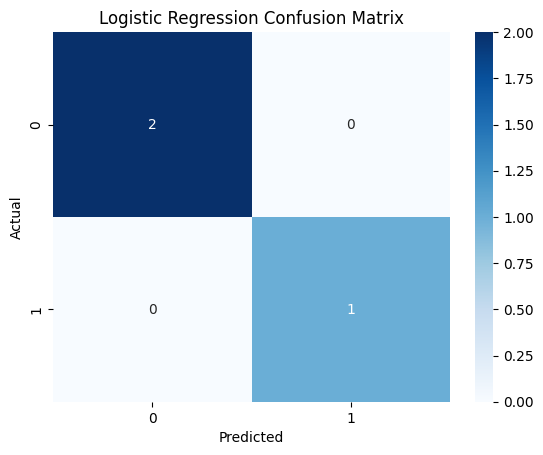

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

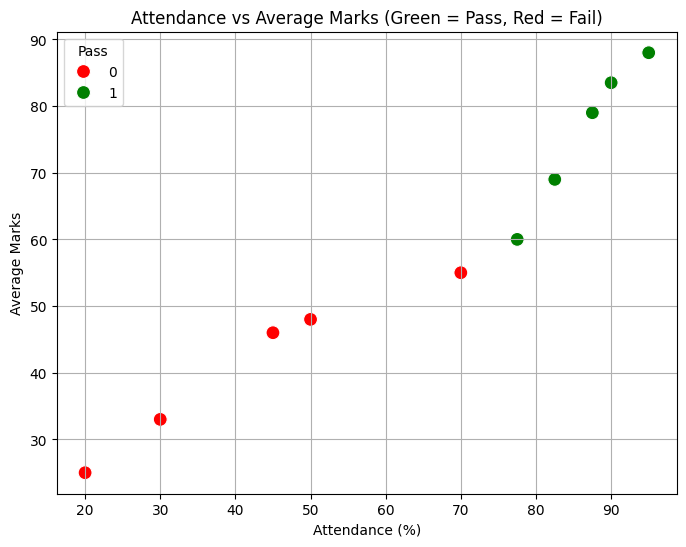

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=merged_df,
    x='AttendancePercent',
    y='AvgMarks',
    hue='Pass',           # color by pass/fail
    palette={1: 'green', 0: 'red'},
    s=100
)
plt.title('Attendance vs Average Marks (Green = Pass, Red = Fail)')
plt.xlabel('Attendance (%)')
plt.ylabel('Average Marks')
plt.grid(True)
plt.show()

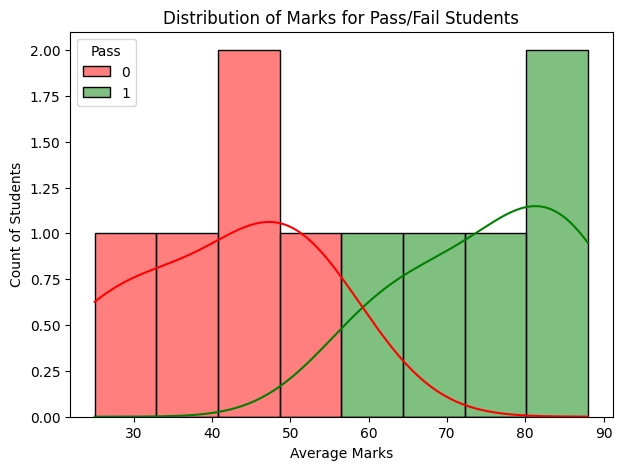

In [19]:
plt.figure(figsize=(7,5))
sns.histplot(data=merged_df, x='AvgMarks', hue='Pass', bins=8, palette={1:'green',0:'red'}, kde=True)
plt.title('Distribution of Marks for Pass/Fail Students')
plt.xlabel('Average Marks')
plt.ylabel('Count of Students')
plt.show()

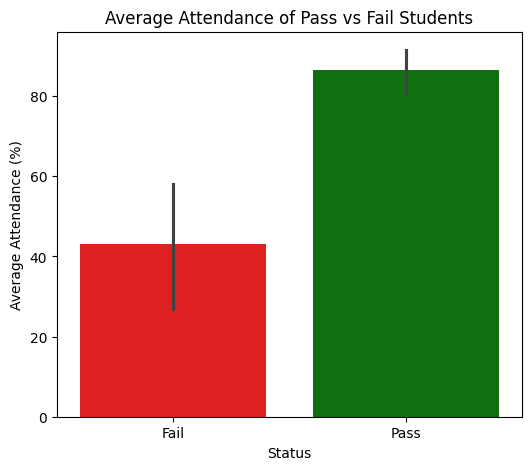

In [20]:
plt.figure(figsize=(6,5))
sns.barplot(
    data=merged_df,
    x='Pass',
    y='AttendancePercent',
    hue='Pass',
    palette={0:'red',1:'green'},
    legend=False
)
plt.xticks([0,1], ['Fail', 'Pass'])
plt.title('Average Attendance of Pass vs Fail Students')
plt.xlabel('Status')
plt.ylabel('Average Attendance (%)')
plt.show()